# Q&A GOOGLE QUEST PROJECT | GROUP 2
**Text Analytics | Prof Evan**

**Group Members:** Tram Ngoc Le, Yanqi Shi, Annuo Qian, Xuejun Shen, Bing Yue Zheng

## Part I: Q&A Category Classification

In Q&A Category Classification part, Google pairs of questions and answers are classified into **5 topics**, including **life/arts, culture, science, technology**, and **stackoverflow** by application of supervised machine learning technique along with text analytics. 

The process of the methodology implementation are set up as below:

- **Step 1. Preliminary steps**  - Set up packages | Load Text | Initial exploratory | Text Preprocessing
- **Step 2. Text Preprocessing** - Stopwords Removal, Stemming, Lowercase, ...etc
- **Step 3. Feature Engineering**  - TFIDF features

- **Step 4. Oversampling** - Handle unbalanced class problem with TFIDF features
- **Step 5. Model Building** - SVM | Naive Bayes | Random Forest | Decision Tree 
- **Step 6. Model Selection** - Model Comparison & Selection - Metrics: Accuracy rate on training data
- **Step 7. Model Evaluation** - Metrics: Accuracy, F1 Score, Precision Score, Recall Score
- **Step 8. Conclusion**
- **Appendix** - Evaluate other features + models that were tried before the best features and best models are created 
- **Reference**
**Note**: *Questions and Answers are categorized seperately*
# ___
## Step 1: Preliminary Steps
- Setup required packages/libraries 

In [99]:
# Set up

import pandas as pd
import numpy as np
import nltk
import re
import gensim
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
# SMOTE
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE #use for oversampling 
from collections import Counter

- Load Data & Examize Training vs Testing
- The Kaggle provide both training and testing data for CATEGORY CLASSIFICATION
- The partition between **training and testing** is **93% - 7%** of the data, respectively

In [207]:
# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [208]:
df_train = train
df_test = test

In [23]:
# Training vs. Testing Ratio
print("Observations for trainning:", len(train),"\nObservations for testing:", len(test))
print("Train-Test:", round((len(train)/(len(train)+len(test)))*100),"-",round((len(test)/(len(train)+len(test)))*100))

Observations for trainning: 6079 
Observations for testing: 476
Train-Test: 93 - 7


- Preprocess Data | Adding category_id to the data set

In [24]:
# Preprocess data
# Reduce the dimension of the original dataset
train = train[['question_body','answer','category']]
test = test[['question_body','answer','category']]

In [35]:
# Setting category id for the target
# Assign ID to 5 values in category 
train['category_id']=train['category'].factorize()[0] 
# Set category to id and id to category
category_id_df = train[['category','category_id']].drop_duplicates().sort_values('category_id')
# Set category to id
category_to_id = dict(category_id_df.values)
# Set id to category
id_to_category = dict(category_id_df[['category_id','category']].values)
print("ID to Category:", id_to_category)
print("Category to ID:", category_to_id)
train.head()

ID to Category: {0: 'LIFE_ARTS', 1: 'CULTURE', 2: 'SCIENCE', 3: 'STACKOVERFLOW', 4: 'TECHNOLOGY'}
Category to ID: {'LIFE_ARTS': 0, 'CULTURE': 1, 'SCIENCE': 2, 'STACKOVERFLOW': 3, 'TECHNOLOGY': 4}


,question_body,answer,category,category_id
0,After playing around with macro photography on...,"I just got extension tubes, so here's the skin...",LIFE_ARTS,0
1,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...,CULTURE,1
2,I'm working on a PCB that has through-hole com...,Do you even need grooves? We make several pro...,SCIENCE,2
3,"An affidavit, from what i understand, is basic...","Sending an ""affidavit"" it is a dispute between...",CULTURE,1
4,I am trying to make a binary image. I want mor...,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,0


- Initial Data Exploratory on Multi-class Target

Observation Distribution in Training Data (%):
TECHNOLOGY       40.0
STACKOVERFLOW    21.0
CULTURE          16.0
SCIENCE          12.0
LIFE_ARTS        12.0
Name: category, dtype: float64


Text(0.5, 1.0, 'Observations Distribution of Classes')

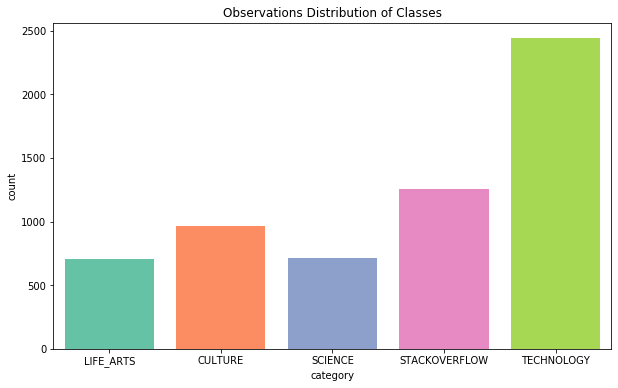

In [89]:
# Number of observations
print("Observation Distribution in Training Data (%):")
print(round((train.category.value_counts()/len(train.category))*100))
# Create a bar chat of distribution of observations for each class
plt.figure(figsize=(10,6))
sns.countplot(x="category", data=train, palette="Set2", saturation = 1).set_title("Observations Distribution of Classes")

### **`Problem - Imbalanced Classes`**

- Based on the **Category** distribution graph, one possible problem has emerged, which is **imbalanced classes**. Number of observations for **Technology** is **extremely higher** than other clasees. When encountering such problem, there are absolutely difficulties with standard algorithms since they can be more biased towards the majority class. Furthermore, it can affect the accuracy rate. 
- However, one **solution** here is **oversampling** the training features before fitting the model. This methodology will be implemented after feature engineering

# ___
## Step 2: Text Preprocessing
- Stopwords Removal
- Stemming & Tokenization
- Lowercase
- Filter out non-character/non-alphabet

In [131]:
from nltk.corpus import stopwords
def preprocessing_text(text):
    # Stopwords Removal
    my_stopwords = stopwords.words('english')
    # Stemming
    wnl = nltk.WordNetLemmatizer()
    tag_remove = re.compile(r'<[^>]+>')
    text = tag_remove.sub('',text)
    text = text.replace("``","")
    # tokenization
    tokens = nltk.word_tokenize(text)
    # alphabet / lowercase / stopwords removal
    words = [w.lower() for w in tokens if w.isalpha if w.lower() not in my_stopwords]
    stem = [wnl.lemmatize(w) for w in words]
    clean_text = ' '.join(w for w in stem)
    return clean_text

In [132]:
# Preprocess ##question for training data
train['question_body'] = train['question_body'].apply(lambda x:preprocessing_text(x))
# Preprocess ##answer for training data
train['answer'] = train['answer'].apply(lambda x:preprocessing_text(x))
# Preprocess ##question for testing data
test['question_body'] = test['question_body'].apply(lambda x:preprocessing_text(x))
# Preprocess ##answer for testing data
test['answer'] = test['answer'].apply(lambda x:preprocessing_text(x))

In [142]:
train_question, test_question, train_labels, test_labels = train.question_body.tolist(), test.question_body.tolist(), train.category.tolist(), test.category.tolist()
train_answer, test_answer, train_labels, test_labels = train.answer.tolist(), test.answer.tolist(), train.category.tolist(), test.category.tolist()

# ___
## Step 3: Feature Engineering

- There are 3 features were created during the process: BOW, TFIDF and Word2Vec. This part demonstrate the **best** feature **TFIDF** that help to achieve the highest accuracy. 
- For information about **BOW** and **Word2Vec**, visit **Step 9: Appendix**

In [143]:
# TFIDF features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, # use logarithmic form for frequency
                                    min_df=1, # The minimum numbers of document a word must be present to be kept
                                   norm='l2', # Ensure all features vectors have a eulicidean norm of 1
                                   encoding='latin-1',
                                   smooth_idf=True,
                                   use_idf=True, 
                                   ngram_range=(1,2)) #unigram and bigram

# QUESTION - TFIDF
tfidf_train_question = tfidf_vectorizer.fit_transform(train_question)
tfidf_test_question = tfidf_vectorizer.transform(test_question)

# ANSWER - TFIDF
tfidf_train_answer = tfidf_vectorizer.fit_transform(train_answer)
tfidf_test_answer = tfidf_vectorizer.transform(test_answer) 

**Find the terms that are the most correlated with each topic**

In [148]:
from sklearn.feature_selection import chi2
features = tfidf_train_question
labels = train.category_id
N = 5 # extract the 5 terms that are most relating to each topic
for category, category_id in sorted(category_to_id.items()):
    features_chi = chi2(features, labels == category_id)
    index = np.argsort(features_chi[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[index]
    unigrams = [w for w in feature_names if len(w.split(' ')) == 1]
    bigrams = [w for w in feature_names if len(w.split(' ')) == 2]
    print("# TOPIC: '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    

# TOPIC: 'CULTURE':
  . Most correlated unigrams:
. freedman
. cdxfriend
. createprojects
. invariance
. myriad
  . Most correlated bigrams:
. lt wbr
. brush wear
. code 2008
. data myt
. anything unlike
# TOPIC: 'LIFE_ARTS':
  . Most correlated unigrams:
. cleartool
. mimicked
. defaultvalues
. bls
. displayalerts
  . Most correlated bigrams:
. asparallel toarray
. ask said
. harder hitting
. library production
. energy lost
# TOPIC: 'SCIENCE':
  . Most correlated unigrams:
. jackson
. daydreaming
. n_4
. logos
. logon
  . Most correlated bigrams:
. heart community
. cmyk point
. hand battlefield
. could think
. expression solution
# TOPIC: 'STACKOVERFLOW':
  . Most correlated unigrams:
. gather
. affixed
. muddy
. doubletree
. debfile
  . Most correlated bigrams:
. different airline
. basically namespace
. level based
. decrease mathcal
. exactly came
# TOPIC: 'TECHNOLOGY':
  . Most correlated unigrams:
. getproductbyid
. invariance
. mediumsize
. dolor
. marvelx42
  . Most correlate

# ___
## Step 4: Over Sampling

- The method of over sampling are used with `SMOTE` - This will randomly oversample obervations for each category until they are equally distributed among the train data. 

- Oversampling is only implemented on texting data

In [158]:
# Setup of packages needed
# SMOTE
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE #use for oversampling
from collections import Counter
# X: input for oversampling
# y: target label for oversampling
oversample = SMOTE()
X_train_question, y_train_question = oversample.fit_resample(tfidf_train_question, train_labels)
X_train_answer, y_train_answer = oversample.fit_resample(tfidf_train_answer, train_labels)

In [159]:
# The distribution of observations in those dataset
Counter(y_train_question)

Counter({'LIFE_ARTS': 2441,
         'CULTURE': 2441,
         'SCIENCE': 2441,
         'STACKOVERFLOW': 2441,
         'TECHNOLOGY': 2441})

In [160]:
Counter(y_train_answer)

Counter({'LIFE_ARTS': 2441,
         'CULTURE': 2441,
         'SCIENCE': 2441,
         'STACKOVERFLOW': 2441,
         'TECHNOLOGY': 2441})

After oversampling, the observations in all category are equal to one another.

# ___
## Step 5: Model Building

- Define matrix for evaluation: Accuracy, Precision, Recall, F1 Score
- Define how to train and evaluate classifiers
- Building the models

In [149]:
# Define matrix for evaluation
from sklearn import metrics
# define a function to evaluate our classification models based on four metrics
def get_metrics(true_labels, predicted_labels): 
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels,
                                                        predicted_labels),5)) 
    print('Precision:', np.round(metrics.precision_score(true_labels,
                                                         predicted_labels,
                                                         average='weighted',
                                                         zero_division=1),5)) 
    # average parameter is required for multiclass target multiple labels
    print('Recall:', np.round(metrics.recall_score(true_labels, 
                                                   predicted_labels,
                                                   average='weighted',
                                                   zero_division=1),5)) 
    # average parameter is required for multiclass target multiple labels
    print('F1 Score:',np.round(metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted',
                                               zero_division=1),5)) 
    # average parameter is required for multiclass target multiple labels
    

In [154]:
# Define a function that trains the model, performs predictions and evaluates the predictions
def train_predict_evaluate_model(classifier,
                                train_features, train_labels,
                                 test_features, test_labels):
    # Build model
    classifier.fit(train_features, train_labels)
    # Predict using model
    predictions = classifier.predict(test_features)
    # Evaluate model prediction performance
    get_metrics(true_labels=test_labels,
               predicted_labels=predictions)
    return predictions

**Model Building for Multi-class Classification**
- Naive Bayes
- Support Vector Machine (SDGC)
- Decision Tree
- Random Forest

In [157]:
# Model Building
from sklearn.naive_bayes import MultinomialNB # Naive Bayes 
from sklearn.linear_model import SGDClassifier # Support Vector Machine (SDG)
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier #RandomForestClassifier

mnb = MultinomialNB() # Naive Bayes
svm = SGDClassifier(loss='hinge', max_iter=100) # SVM SDG
dct = DecisionTreeClassifier(criterion = "entropy", # Decision Tree
                             # set criterion as entropy for the information gain 
                             #(measure the quality of the split)
                             random_state = 0)
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0) # Random Forest

# ___
## Step 6: Model Selection
- Fit and evaluate Naive Bayes, SVM, Decision Tree & Random Forest with TFIDF
- Evaluate the models based on the accuracy rate from the training set
- Models accuracy visualization

### **`Note`**

*This section **only features the models selection regarding TFIDF** - which are the **best models** built with the best feature regarding the category classification project.*

*For further details on **other models selections** , please refers to **Step 9: Appendix**, which includes all the models and features we have tried before come up with the best model.*

In [161]:
# Set up
models = [mnb, svm, dct, rf]
cross_validation = 5 # 5-fold cross validation
cv_tfidf = pd.DataFrame(index=range(cross_validation*len(models)))

### A. Question - Category Classification

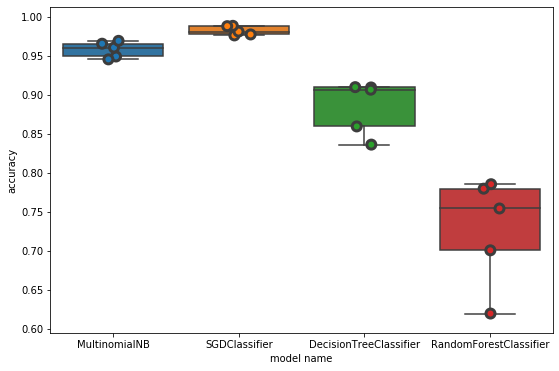

model name
DecisionTreeClassifier    0.884310
MultinomialNB             0.958050
RandomForestClassifier    0.727816
SGDClassifier             0.982302
Name: accuracy, dtype: float64

In [164]:
entry = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,X_train_question,y_train_question,scoring='accuracy',cv=cross_validation)
    for fold_index, accuracy in enumerate(accuracies):
        entry.append((model_name,fold_index,accuracy))
    cv_tfidf=pd.DataFrame(entry, columns=['model name','fold_idx','accuracy'])

plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_tfidf)
sns.stripplot(x='model name',y='accuracy',data=cv_tfidf,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_tfidf.groupby('model name').accuracy.mean() # The accuracy mean of those models

#### **`Discussion | Question Category Classification | Model Selection`**
- **Support Vector Machine** (SGDClassifier) performs the **best** with the highest accuracy rate of approximately **98%** on training data.
- **Naive Bayes** performs **slightly less accurate** comparing to **Support Vector Machine** by **3%** on training data. 
- **Random Forest** and **Decision Tree** do not perform as well as other models on training data.
#### => CONCLUSION: SUPPORT VECTOR MACHINE - 98% OF ACCURACY ON TRAINING

### B. Answer - Category Classification

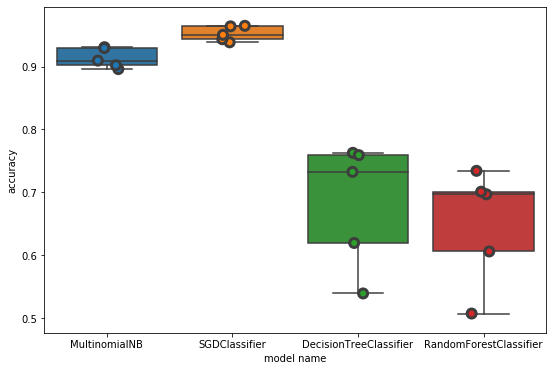

model name
DecisionTreeClassifier    0.682589
MultinomialNB             0.913560
RandomForestClassifier    0.648996
SGDClassifier             0.952233
Name: accuracy, dtype: float64

In [165]:
# Answer model selection
entry = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,X_train_answer,y_train_answer,scoring='accuracy',cv=cross_validation)
    for fold_index, accuracy in enumerate(accuracies):
        entry.append((model_name,fold_index,accuracy))
    cv_tfidf=pd.DataFrame(entry, columns=['model name','fold_idx','accuracy'])

plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_tfidf)
sns.stripplot(x='model name',y='accuracy',data=cv_tfidf,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_tfidf.groupby('model name').accuracy.mean() # The accuracy mean of those models

#### **`Discussion | Answer Category Classification | Model Selection`**
- **Support Vector Machine** (SGDClassifier) performs the **best** with the highest accuracy rate of approximately **95%** on training data.
- **Naive Bayes** performs **slightly less accurate**, with **91%**, comparing to **Support Vector Machine** by **3%** on training data. 
- **Random Forest** and **Decision Tree** do not perform as well as other models on training data. The accuracy for those models are roughly **64%** and **68%**, repectively
#### => CONCLUSION: SUPPORT VECTOR MACHINE - 95% OF ACCURACY ON TRAINING

# ___
## Step 7: Model Evaluations | Support Vector Machine 
- Fit the best model and evaluate on the **testing set**
- Confusion Matrix

### A. Question | SVM{TFIDF} Evaluation

In [180]:
# Question
svm_tfidf_predictions_question = train_predict_evaluate_model(classifier=svm,
                                                 train_features=X_train_question,
                                                 train_labels=y_train_question,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.7458
Precision: 0.74672
Recall: 0.7458
F1 Score: 0.74467


### **`Question | Confusion Matrix`**

- Using `metrics.confusion_matrix` from scikitlearn to create the confusion matrix for predictions
- Visualize confusion matrix with `heatmap` from `seaborn`

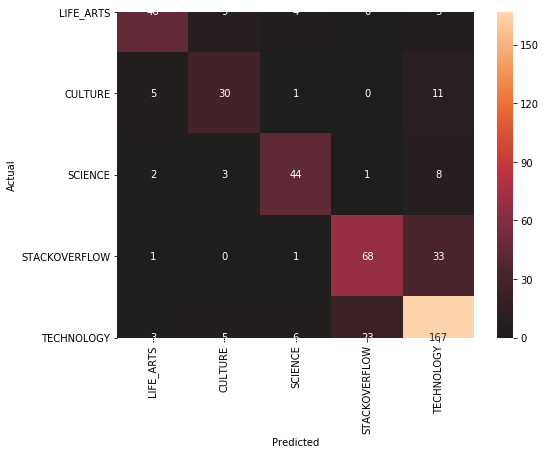

In [201]:
# Create a confusion matrix for question
cm_q = metrics.confusion_matrix(test_labels,svm_tfidf_predictions_question)
# Visualize the confusion matrix with heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_q,
           annot = True,
           fmt = "d",
           center = 0,
           xticklabels = category_id_df.category.values,
           yticklabels = category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [204]:
# Evaluate each category
print(metrics.classification_report(test_labels, svm_tfidf_predictions_question, target_names=train['category'].unique()))

               precision    recall  f1-score   support

    LIFE_ARTS       0.81      0.72      0.76        64
      CULTURE       0.64      0.64      0.64        47
      SCIENCE       0.79      0.76      0.77        58
STACKOVERFLOW       0.74      0.66      0.70       103
   TECHNOLOGY       0.75      0.82      0.78       204

     accuracy                           0.75       476
    macro avg       0.74      0.72      0.73       476
 weighted avg       0.75      0.75      0.74       476



In [205]:
cm_q

array([[ 46,   9,   4,   0,   5],
       [  5,  30,   1,   0,  11],
       [  2,   3,  44,   1,   8],
       [  1,   0,   1,  68,  33],
       [  3,   5,   6,  23, 167]], dtype=int64)

### **`Examples of miss classification`**

In [209]:
num = 0
for document, label, predicted_label in zip(df_test.question_body,test_labels, svm_tfidf_predictions_question):
    if predicted_label != label:
        print('Actual Label:', label)
        print('Predicted Label:', predicted_label)
        print('Document:-')
        print(re.sub('\n',' ', document))
        num += 1
        if num == 5:
            break

Actual Label: CULTURE
Predicted Label: LIFE_ARTS
Document:-
I see questions/information online about how to get rid of corpses but I'm not sure what the consequences to having them lying around are.  I know that I can use a morgue to store them and that they will eventually be taken away in a hearse. However, I've always just left them lying around. This doesn't seem to have any obvious consequences.  Do they upset prisoners or staff (e.g. increasing the danger level beyond what death normally does)? Make them sick? Slow down pathing? Is this something that's not implemented yet or is leaving dead bodies all over the place meant to be completely fine?  The wiki's pages for Death and Morgue don't shed any light on this. All I'm finding is the how of getting rid of corpses/glitches related to it but not why it matters in the first place. All I've seen that's related is that apparently prisoners can loot guard corpses for keys, but there's no obvious consequences for prisoner corpses whic

### B. Answer | SVM{TFIDF} Evaluation

In [210]:
# Answer
svm_tfidf_predictions_answer = train_predict_evaluate_model(classifier=svm,
                                                 train_features=X_train_answer,
                                                 train_labels=y_train_answer,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.73739
Precision: 0.73556
Recall: 0.73739
F1 Score: 0.73464


### **`Answer | Confusion Matrix`**

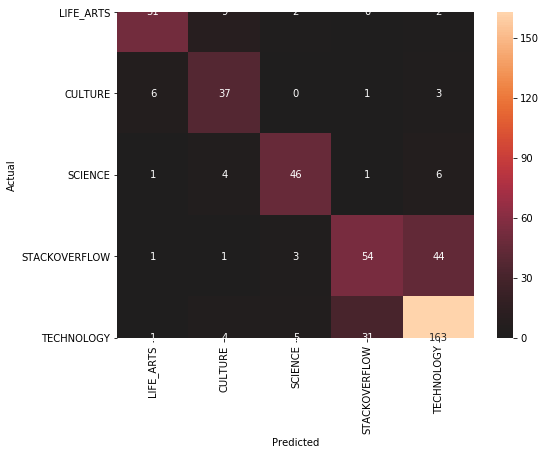

In [211]:
# Create a confusion matrix for question
cm_a = metrics.confusion_matrix(test_labels,svm_tfidf_predictions_answer)
# Visualize the confusion matrix with heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_a,
           annot = True,
           fmt = "d",
           center = 0,
           xticklabels = category_id_df.category.values,
           yticklabels = category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [212]:
# Evaluate each category
print(metrics.classification_report(test_labels, svm_tfidf_predictions_answer, target_names=train['category'].unique()))

               precision    recall  f1-score   support

    LIFE_ARTS       0.85      0.80      0.82        64
      CULTURE       0.67      0.79      0.73        47
      SCIENCE       0.82      0.79      0.81        58
STACKOVERFLOW       0.62      0.52      0.57       103
   TECHNOLOGY       0.75      0.80      0.77       204

     accuracy                           0.74       476
    macro avg       0.74      0.74      0.74       476
 weighted avg       0.74      0.74      0.73       476



In [213]:
cm_a

array([[ 51,   9,   2,   0,   2],
       [  6,  37,   0,   1,   3],
       [  1,   4,  46,   1,   6],
       [  1,   1,   3,  54,  44],
       [  1,   4,   5,  31, 163]], dtype=int64)

### **`Examples of Misclassification`

In [214]:
num = 0
for document, label, predicted_label in zip(df_test.answer,test_labels, svm_tfidf_predictions_answer):
    if predicted_label != label
        print('Actual Label:', label)
        print('Predicted Label:', predicted_label)
        print('Document:-')
        print(re.sub('\n',' ', document))
        num += 1
        if num == 5:
            break

Actual Label: CULTURE
Predicted Label: LIFE_ARTS
Document:-
There is no consequence for leaving corpses anywhere. All it does if leave a mark of failure in your path of making a fully functional prison. 
Actual Label: LIFE_ARTS
Predicted Label: CULTURE
Document:-
Opinion: It was a funny(?) joke.  Although a similar setup was used in Knocked Up, the truth is similar setups have been used in plenty of comedy movies.  Whilst I understand your query regarding the censors, it seems difficult to imagine why censorship would be an issue, the main reason I can think of being:   There is a colossal amount of crass language, violence, partial nudity and drug taking in the film. Why would all this be considered acceptable but a line about rape wouldn't be?   It seems more likely to me that it was a funny line that works in the context of the scene as it seems so abhorrent that he can't bring himself to utter the actual word, instead resorting to childish rhyming (suggesting the mere thought of it

### C. Pair of Question/Answer Evaluation

In [215]:
test['predicted_question'] = svm_tfidf_predictions_question
test['predicted_answer'] = svm_tfidf_predictions_answer

In [216]:
test.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,predicted_question,predicted_answer
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com,LIFE_ARTS,LIFE_ARTS
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com,TECHNOLOGY,TECHNOLOGY
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com,LIFE_ARTS,CULTURE
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com,TECHNOLOGY,TECHNOLOGY
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com,CULTURE,CULTURE


In [220]:
# Check to see if the pair of question and answer is predicted as the same category
Count = []
for i in range(0, len(test)):
    if test['predicted_question'][i] == test['predicted_answer'][i] and test['predicted_question'][i] == test['category'][i]:
        a = "correct"
    else:
        a = "incorrect"
    Count.append(a)

In [221]:
test['qa_pair_prediction'] = Count

In [222]:
test.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,predicted_question,predicted_answer,qa_pair_prediction
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com,LIFE_ARTS,LIFE_ARTS,incorrect
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com,TECHNOLOGY,TECHNOLOGY,correct
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com,LIFE_ARTS,CULTURE,incorrect
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com,TECHNOLOGY,TECHNOLOGY,correct
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com,CULTURE,CULTURE,correct


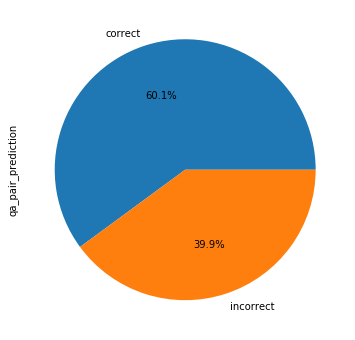

In [287]:
plt.figure(figsize=(6,6))
test.qa_pair_prediction.value_counts().plot(kind='pie',autopct = '%1.1f%%')

# ____
## Step 8: Conclusion

### `Feature`
- TFIDF features | Stopwords Removal | Stemming | Unigram & Bigram Combination | logarithmic for frequency | minimum numbers of document a word must be present to kept is 1 

### `Model`
- Supported Vector Machine

### `Evaluation`
- **Question Accuracy:** 98% on training | 74% on testing
- **Answer Accuracy:** 95% on training | 73% on testing
- **Pair of Question & Answer Accuracy:** 60.1% correct on testing - combination of the answer and question predicted labels - we don't actually fit the pair of Google qa in the model for this part

### `Reasoning`
- In multiclassification problem, we still need to have a balanced data for a better model performance. However, with 5 target in the dataset, which means if we randomly pick 1 to predict the accuracy would be 100%/5=20%, which is the baseline for predictions - Therefore, the accuracy rate of 74% and 73% on testing exceed the the baseline more than 3 times. The model does perform good enough under this circumstances.

# ___
## Step 9: Appendix

### A. Feature Engineering

### `BOW | Unigram`

In [239]:
from sklearn.feature_extraction.text import CountVectorizer #tokenizes, count words
bow_vectorizer = CountVectorizer(lowercase=True, # Lowercase
                                min_df=1,
                                ngram_range=(1,1)) # unigram
# QUESTION features engineering
bow_train_question = bow_vectorizer.fit_transform(train_question)
bow_test_question = bow_vectorizer.transform(test_question)

# ANSWER features engineering
bow_train_answer = bow_vectorizer.fit_transform(train_answer)
bow_test_answer = bow_vectorizer.transform(test_answer)

### `Word2Vec`

In [297]:
# tokenize documents for word2vec
tokenized_train_question = [nltk.word_tokenize(text)
                   for text in train_question]
tokenized_test_question = [nltk.word_tokenize(text)
                   for text in test_question]
tokenized_train_answer = [nltk.word_tokenize(text)
                   for text in train_answer] 
tokenized_test_answer = [nltk.word_tokenize(text)
                   for text in test_answer]  

# build word2vec model for question                 
wv_model_q = gensim.models.Word2Vec(tokenized_train_question,
                               size=200,                          #set the size or dimension for the word vectors 
                               window=60,                        #specify the length of the window of words taken as context
                               min_count=10)                   #ignores all words with total frequency lower than                     

# build word2vec model for answer                 
wv_model_a = gensim.models.Word2Vec(tokenized_train_answer,
                               size=200,                          #set the size or dimension for the word vectors 
                               window=60,                        #specify the length of the window of words taken as context
                               min_count=10)                   #ignores all words with total frequency lower than                     

In [298]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector 
   

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

# averaged word vector features from word2vec
avg_wv_trainq_features = averaged_word_vectorizer(corpus=tokenized_train_question,
                                                 model=wv_model_q ,
                                                 num_features=200) 
avg_wv_testq_features = averaged_word_vectorizer(corpus=tokenized_test_question,
                                                 model=wv_model_q ,
                                                 num_features=200)
avg_wv_traina_features = averaged_word_vectorizer(corpus=tokenized_train_answer,
                                                 model=wv_model_a,
                                                 num_features=200)
avg_wv_testa_features = averaged_word_vectorizer(corpus=tokenized_test_answer,
                                                model=wv_model_a,
                                                num_features=200) 

C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


**Over Sampling**

In [310]:
oversample = SMOTE()
X, y = oversample.fit_resample(bow_train_question, train_labels)
A, b = oversample.fit_resample(bow_train_answer,train_labels)
w2v_q, q_labels = oversample.fit_resample(avg_wv_trainq_features, train_labels)
w2v_a, a_labels = oversample.fit_resample(avg_wv_traina_features, train_labels)

## B. Model Fitting & Evaluation

# `BOW Feature`

- Naive Bayes tend to perform the best with BOW features yet the accuracy rate is not as high as TFIDF features

### Question

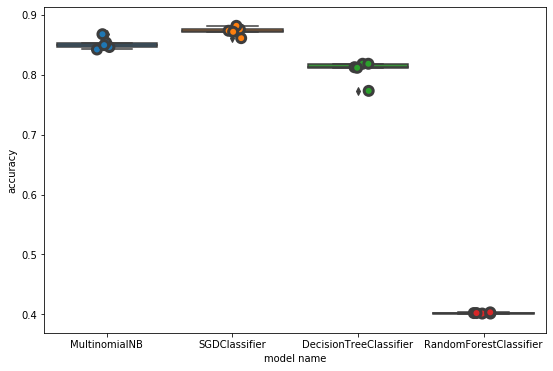

model name
DecisionTreeClassifier    0.806712
MultinomialNB             0.851784
RandomForestClassifier    0.402040
SGDClassifier             0.872676
Name: accuracy, dtype: float64

In [281]:
models = [mnb, svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_bow = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,bow_train_question,train_labels,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_bow=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_bow)
sns.stripplot(x='model name',y='accuracy',data=cv_df_bow,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_bow.groupby('model name').accuracy.mean()

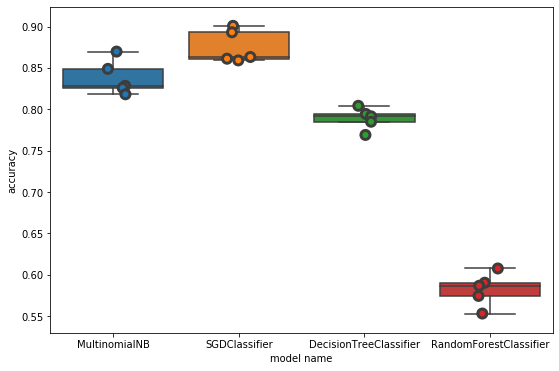

model name
DecisionTreeClassifier    0.788775
MultinomialNB             0.838181
RandomForestClassifier    0.582384
SGDClassifier             0.875461
Name: accuracy, dtype: float64

In [283]:
# Over Sampling Question BOW
models = [mnb, svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_bow = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,X,y,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_bow=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_bow)
sns.stripplot(x='model name',y='accuracy',data=cv_df_bow,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_bow.groupby('model name').accuracy.mean()

### Answer

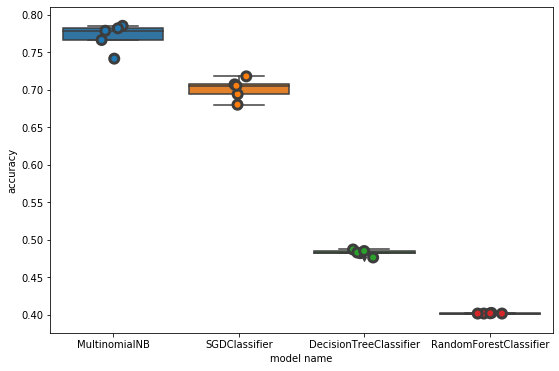

model name
DecisionTreeClassifier    0.482481
MultinomialNB             0.770846
RandomForestClassifier    0.401546
SGDClassifier             0.700938
Name: accuracy, dtype: float64

In [280]:
# Answer
models = [mnb, svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_bow = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,bow_train_answer,train_labels,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_bow=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_bow)
sns.stripplot(x='model name',y='accuracy',data=cv_df_bow,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_bow.groupby('model name').accuracy.mean()

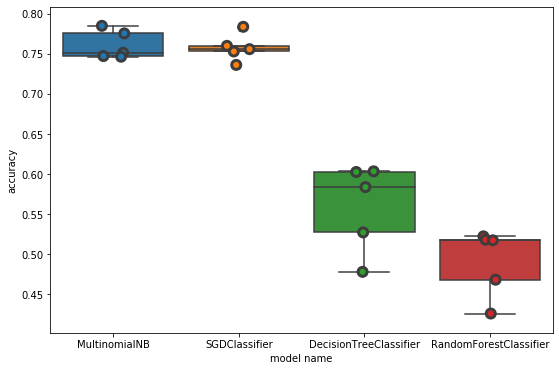

model name
DecisionTreeClassifier    0.559033
MultinomialNB             0.761082
RandomForestClassifier    0.490455
SGDClassifier             0.757722
Name: accuracy, dtype: float64

In [284]:
# Over Sampling Answer BOW
models = [mnb, svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_bow = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,A,b,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_bow=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_bow)
sns.stripplot(x='model name',y='accuracy',data=cv_df_bow,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_bow.groupby('model name').accuracy.mean()

## `Note` 
**In comparison with TFIDF and those 4 models, TFIDF still have better performance after being over sampling than BOW** 

# ___
##  SVM {BOW | Unigram}

- In the case of SVM with BOW - oversampling decreases the accuracy rate of the models - **OVER SAMPLING do not work** in this case
- The accuracy rate on testing data for both answers and questions are roughly **65%**

## `Question`

In [241]:
# Question: Support Vector Machine | BOW
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                                 train_features=bow_train_question,
                                                 train_labels=train_labels,
                                                 test_features=bow_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.64286
Precision: 0.64205
Recall: 0.64286
F1 Score: 0.64197


In [256]:
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                                 train_features=X,
                                                 train_labels=y,
                                                 test_features=bow_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.61555
Precision: 0.63091
Recall: 0.61555
F1 Score: 0.61884


## `Answer`

In [240]:
# Answer: Support Vector Machine BOW
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                                 train_features=bow_train_answer,
                                                 train_labels=train_labels,
                                                 test_features=bow_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.65336
Precision: 0.65941
Recall: 0.65336
F1 Score: 0.65517


In [261]:
# Oversampling
# Answer: Support Vector Machine BOW
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                                 train_features=A,
                                                 train_labels=b,
                                                 test_features=bow_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.60294
Precision: 0.61012
Recall: 0.60294
F1 Score: 0.60397


##  Decision Tree  {BOW | Unigram}

- Decision Tree on BOW shows a very low accuracy rate - roughly 47% ~ 49% on testing data set
- Oversampling do not work in this case since it decreases the accuracy of decision tree by 10% for both question and answer category classification

### `Question`

In [263]:
# Not over sampling
# Question: Decision Tree | BOW
dct_bow_predictions = train_predict_evaluate_model(classifier=dct,
                                                 train_features=bow_train_question,
                                                 train_labels=train_labels,
                                                 test_features=bow_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.4916
Precision: 0.48683
Recall: 0.4916
F1 Score: 0.48423


In [265]:
# Over sampling
# Question: Decision Tree | BOW
dct_bow_predictions = train_predict_evaluate_model(classifier=dct,
                                                 train_features=X,
                                                 train_labels=y,
                                                 test_features=bow_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.40966
Precision: 0.43839
Recall: 0.40966
F1 Score: 0.41476


## `Answer`

In [243]:
# Answer: Decision Tree | BOW
dct_bow_predictions = train_predict_evaluate_model(classifier=dct,
                                                 train_features=bow_train_answer,
                                                 train_labels=train_labels,
                                                 test_features=bow_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.47479
Precision: 0.46931
Recall: 0.47479
F1 Score: 0.47126


In [262]:
# Over Samppling
# Answer: Decision Tree | BOW
dct_bow_predictions = train_predict_evaluate_model(classifier=dct,
                                                 train_features=A,
                                                 train_labels=b,
                                                 test_features=bow_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.44538
Precision: 0.4597
Recall: 0.44538
F1 Score: 0.44658


##  Naive Bayes  {BOW | Unigram}

- Naive Bayes works the best with BOW with 72% accuracy roughly on both question and answer
- However, the over sampling does not work in this case because it decrease the accuracy of Naive Bayes

## ` Question`

In [270]:
# Question: Naive Bayes | BOW
mnb_bow_predictions_question = train_predict_evaluate_model(classifier=mnb,
                                            train_features=bow_train_question,
                                            train_labels=train_labels,
                                            test_features=bow_test_question,
                                            test_labels=test_labels)

Accuracy: 0.72269
Precision: 0.72444
Recall: 0.72269
F1 Score: 0.71833


In [269]:
# Question - Oversampling
mnb_bow_predictions_answer = train_predict_evaluate_model(classifier=mnb,
                                            train_features=X,
                                            train_labels=y,
                                            test_features=bow_test_question,
                                            test_labels=test_labels)

Accuracy: 0.72899
Precision: 0.73178
Recall: 0.72899
F1 Score: 0.72611


## `Answer`

In [252]:
# Answer: Naive Bayes | BOW
mnb_bow_predictions_answer = train_predict_evaluate_model(classifier=mnb,
                                            train_features=bow_train_answer,
                                            train_labels=train_labels,
                                            test_features=bow_test_answer,
                                            test_labels=test_labels)

Accuracy: 0.73739
Precision: 0.73872
Recall: 0.73739
F1 Score: 0.73071


In [268]:
# Over Sampling
# Answer: Naive Bayes | BOW
mnb_bow_predictions_answer = train_predict_evaluate_model(classifier=mnb,
                                            train_features=A,
                                            train_labels=b,
                                            test_features=bow_test_answer,
                                            test_labels=test_labels)

Accuracy: 0.72479
Precision: 0.72527
Recall: 0.72479
F1 Score: 0.72279


## Random Forest {BOW | Unigram}

- Oversampling works with Random Forest and increased the accuracy by 10%
- Yet the accuracy of random forest is still roughly 50% to 49%

## `Question`

In [276]:
# Question
rf_bow_predictions_question = train_predict_evaluate_model(classifier=rf,
                                            train_features=bow_train_question,
                                            train_labels=train_labels,
                                            test_features=bow_test_question,
                                            test_labels=test_labels)

Accuracy: 0.42857
Precision: 0.7551
Recall: 0.42857
F1 Score: 0.25714


In [275]:
# Oversampling quesiton
rf_bow_predictions_question = train_predict_evaluate_model(classifier=rf,
                                            train_features=X,
                                            train_labels=y,
                                            test_features=bow_test_question,
                                            test_labels=test_labels)

Accuracy: 0.53992
Precision: 0.57838
Recall: 0.53992
F1 Score: 0.53754


## `Answer`

In [278]:
# Answer
rf_tfidf_predictions_question = train_predict_evaluate_model(classifier=rf,
                                            train_features=bow_train_answer,
                                            train_labels=train_labels,
                                            test_features=bow_test_answer,
                                            test_labels=test_labels)

Accuracy: 0.42857
Precision: 0.7551
Recall: 0.42857
F1 Score: 0.25714


In [279]:
# Answer
rf_tfidf_predictions_question = train_predict_evaluate_model(classifier=rf,
                                            train_features=A,
                                            train_labels=b,
                                            test_features=bow_test_answer,
                                            test_labels=test_labels)

Accuracy: 0.5105
Precision: 0.5159
Recall: 0.5105
F1 Score: 0.50899


# ____
# `TFIDF Features` - NOT OVERSAMPLING

As observed in the plot below, the accuracy rate on TFIDF features without oversampling is lower than TFIDF with over sampling (in the main submission) - Therefore we don't have to consider TFIDF that are not over sampling

As observed accuracy rate on testing dataset, SVM (in part 6) with TFIDF still performs with the highest accuracy rate on both testing and training dataset 
Therefore, we go with SVM 



### Question

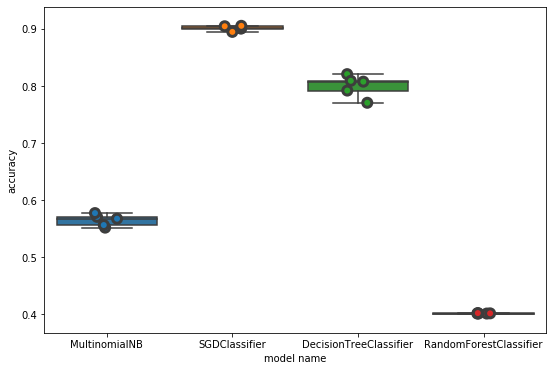

model name
DecisionTreeClassifier    0.799969
MultinomialNB             0.564730
RandomForestClassifier    0.401546
SGDClassifier             0.901300
Name: accuracy, dtype: float64

In [327]:

# Answer
models = [mnb, svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_tfidf = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,tfidf_train_question,train_labels,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_tfidf=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_tfidf)
sns.stripplot(x='model name',y='accuracy',data=cv_df_tfidf,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_tfidf.groupby('model name').accuracy.mean()

### Answer

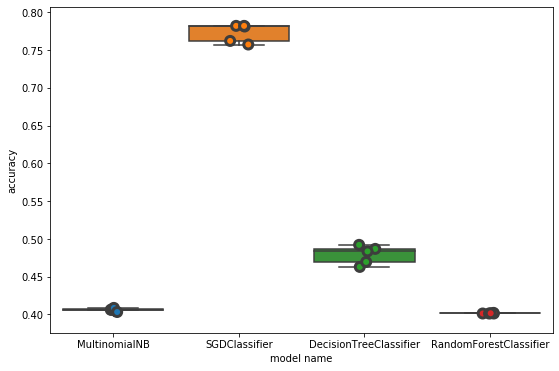

model name
DecisionTreeClassifier    0.479028
MultinomialNB             0.406481
RandomForestClassifier    0.401546
SGDClassifier             0.772987
Name: accuracy, dtype: float64

In [328]:
# Answer
models = [mnb, svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_tfidf = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,tfidf_train_answer,train_labels,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_tfidf=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_tfidf)
sns.stripplot(x='model name',y='accuracy',data=cv_df_tfidf,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_tfidf.groupby('model name').accuracy.mean()

## Decision Tree {TFIDF | Oversampling |Unigram & Bigram}

## `Question`

In [290]:
# Question: Decision Tree | TFIDF Features
dct_tfidf_predictions = train_predict_evaluate_model(classifier=dct,
                                                  train_features=X_train_question,
                                                 train_labels=y_train_question,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.43067
Precision: 0.43184
Recall: 0.43067
F1 Score: 0.43004


## `Answer`

In [291]:
# Answer Decision Tree | TFIDF Features
dct_tfidf_predictions = train_predict_evaluate_model(classifier=dct,
                                                  train_features=X_train_answer,
                                                 train_labels=y_train_answer,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.48529
Precision: 0.4785
Recall: 0.48529
F1 Score: 0.48072


## Random Forest {TFIDF| Oversampling| Unigram & Bigram}

## `Question`

In [293]:
# Question: Decision Tree | TFIDF Features
rf_tfidf_predictions = train_predict_evaluate_model(classifier=rf,
                                                  train_features=X_train_question,
                                                 train_labels=y_train_question,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.57563
Precision: 0.61671
Recall: 0.57563
F1 Score: 0.58112


## `Answer`

In [294]:
# Answer Decision Tree | TFIDF Features
rf_tfidf_predictions = train_predict_evaluate_model(classifier=rf,
                                                  train_features=X_train_answer,
                                                 train_labels=y_train_answer,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.5063
Precision: 0.58209
Recall: 0.5063
F1 Score: 0.5108


## Naive Bayes {TFIDF | Oversampling |Unigram & Bigram}

## `Question`

In [296]:
# Question: Decision Tree | TFIDF Features
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=mnb,
                                                  train_features=X_train_question,
                                                 train_labels=y_train_question,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_labels)

Accuracy: 0.69958
Precision: 0.73842
Recall: 0.69958
F1 Score: 0.70293


## `Answer`

In [295]:
# Answer Decision Tree | TFIDF Features
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=mnb,
                                                  train_features=X_train_answer,
                                                 train_labels=y_train_answer,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_labels)

Accuracy: 0.69748
Precision: 0.72507
Recall: 0.69748
F1 Score: 0.70154


# __________
# `Word2Vec`

Eventhough oversampling does increased accuracy for those model but not much when comparing to other model. Word2Vec is underperform

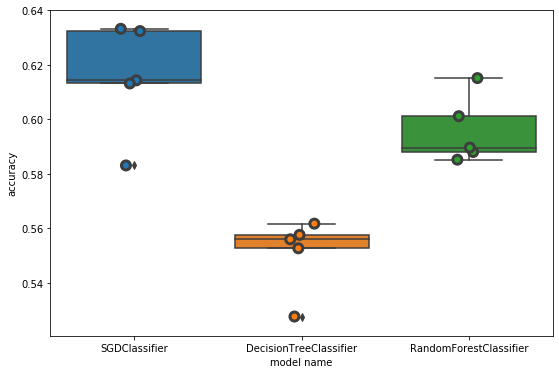

model name
DecisionTreeClassifier    0.551074
RandomForestClassifier    0.595820
SGDClassifier             0.615232
Name: accuracy, dtype: float64

In [329]:
# Question
models = [ svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_w2v = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,avg_wv_traina_features,train_labels,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_w2v=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_w2v)
sns.stripplot(x='model name',y='accuracy',data=cv_df_w2v,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_w2v.groupby('model name').accuracy.mean()

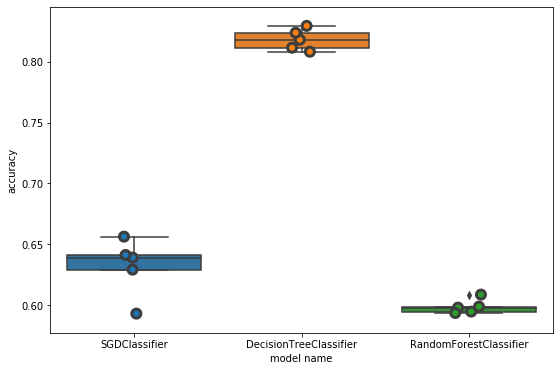

model name
DecisionTreeClassifier    0.818393
RandomForestClassifier    0.598617
SGDClassifier             0.631684
Name: accuracy, dtype: float64

In [330]:
# Answer
models = [ svm, dct, rf]
from sklearn.model_selection import cross_val_score
# Fitting the model into a plot
CV = 5 # 5-fold cross validation
cv_df_w2v = pd.DataFrame(index=range(CV*len(models)))
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,avg_wv_trainq_features,train_labels,scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))
    cv_df_w2v=pd.DataFrame(entries, columns=['model name','fold_idx','accuracy'])

# Build a plots to visualize the model selections
plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_df_w2v)
sns.stripplot(x='model name',y='accuracy',data=cv_df_w2v,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_df_w2v.groupby('model name').accuracy.mean()

## SVM {word2vec}
## `Question`

In [311]:
# Question: Support Vector Machine | Word2vec
svm_wv_predictions_q = train_predict_evaluate_model(classifier=svm,
                                                 train_features=avg_wv_trainq_features,
                                                 train_labels=train_labels,
                                                 test_features=avg_wv_testq_features,
                                                 test_labels=test_labels)

Accuracy: 0.58193
Precision: 0.60266
Recall: 0.58193
F1 Score: 0.57298


In [312]:
# Question: Support Vector Machine | Word2vec #Oversampling
svm_wv_predictions_q = train_predict_evaluate_model(classifier=svm,
                                                 train_features=w2v_q,
                                                 train_labels=q_labels,
                                                 test_features=avg_wv_testq_features,
                                                 test_labels=test_labels)

Accuracy: 0.58613
Precision: 0.63231
Recall: 0.58613
F1 Score: 0.58528


## `Answer`

In [313]:
# Answer: Support Vector Machine | Word2vec
svm_wv_predictions_a = train_predict_evaluate_model(classifier=svm,
                                                 train_features=avg_wv_traina_features,
                                                 train_labels=train_labels,
                                                 test_features=avg_wv_testa_features,
                                                 test_labels=test_labels)

Accuracy: 0.63866
Precision: 0.6373
Recall: 0.63866
F1 Score: 0.63771


In [314]:
# Answer: Support Vector Machine | Word2vec
svm_wv_predictions_a = train_predict_evaluate_model(classifier=svm,
                                                 train_features=w2v_a,
                                                 train_labels=a_labels,
                                                 test_features=avg_wv_testa_features,
                                                 test_labels=test_labels)

Accuracy: 0.56513
Precision: 0.59781
Recall: 0.56513
F1 Score: 0.56487


## Decision Tree {word2vec}
## `Question`

In [317]:
# Question: Decision Tree | Word2vec
dct_wv_predictions_q = train_predict_evaluate_model(classifier=dct,
                                                 train_features=avg_wv_trainq_features,
                                                 train_labels=train_labels,
                                                 test_features=avg_wv_testq_features,
                                                 test_labels=test_labels)

Accuracy: 0.51681
Precision: 0.5237
Recall: 0.51681
F1 Score: 0.51831


In [318]:
# Question: Decision Tree | Word2vec # Oversampling
dct_wv_predictions_q = train_predict_evaluate_model(classifier=dct,
                                                 train_features=w2v_q,
                                                 train_labels=q_labels,
                                                 test_features=avg_wv_testq_features,
                                                 test_labels=test_labels)

Accuracy: 0.4958
Precision: 0.50449
Recall: 0.4958
F1 Score: 0.49897


## `Answer`

In [319]:
# Answer: Decision Tree | Word2vec 
dct_wv_predictions_a = train_predict_evaluate_model(classifier=dct,
                                                 train_features=avg_wv_traina_features,
                                                 train_labels=train_labels,
                                                 test_features=avg_wv_testa_features,
                                                 test_labels=test_labels)

Accuracy: 0.57143
Precision: 0.56992
Recall: 0.57143
F1 Score: 0.56995


In [320]:
# Answer Decision Tree Oversampling
dtc_wv_predictions_a = train_predict_evaluate_model(classifier=dct,
                                                 train_features=w2v_a,
                                                 train_labels=a_labels,
                                                 test_features=avg_wv_testa_features,
                                                 test_labels=test_labels)

Accuracy: 0.53151
Precision: 0.55481
Recall: 0.53151
F1 Score: 0.53776


## Random Forest {word2vec}

## `Question`

In [304]:
# Question: Random Forest| Word2vec
rf_wv_predictions_q = train_predict_evaluate_model(classifier=rf,
                                                 train_features=avg_wv_trainq_features,
                                                 train_labels=train_labels,
                                                 test_features=avg_wv_testq_features,
                                                 test_labels=test_labels)

Accuracy: 0.59874
Precision: 0.66562
Recall: 0.59874
F1 Score: 0.55853


In [307]:
# Oversampling
# Question: Random Forest | Word2vec
rf_wv_predictions_q = train_predict_evaluate_model(classifier=rf,
                                                 train_features=w2v_q,
                                                 train_labels=q_labels,
                                                 test_features=avg_wv_testq_features,
                                                 test_labels=test_labels)

Accuracy: 0.57773
Precision: 0.6182
Recall: 0.57773
F1 Score: 0.5869


## `Answer`

In [305]:
# Answer: Random Forest | Word2vec
rf_wv_predictions_a = train_predict_evaluate_model(classifier=rf,
                                                 train_features=avg_wv_traina_features,
                                                 train_labels=train_labels,
                                                 test_features=avg_wv_testa_features,
                                                 test_labels=test_labels)

Accuracy: 0.62185
Precision: 0.68274
Recall: 0.62185
F1 Score: 0.57746


In [321]:
# Answer Random Forest Oversampling
rf_wv_predictions_a = train_predict_evaluate_model(classifier=rf,
                                                 train_features=w2v_a,
                                                 train_labels=a_labels,
                                                 test_features=avg_wv_testa_features,
                                                 test_labels=test_labels)

Accuracy: 0.55882
Precision: 0.60534
Recall: 0.55882
F1 Score: 0.56437


# References

1. Towards Data Science | Multiclass Text Classification with scikitlearn - https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
2. Towards Data Science | Machine Learning Multiclass Classification with imbalanced data set https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a
3. Machine Learning Mastery | A Gentle Introduction to Imbalanced Classification https://machinelearningmastery.com/what-is-imbalanced-classification/
4. Kaggle | Best Algorithm for Classification https://www.kaggle.com/getting-started/42409
5. Medium | Tips and Tricks for Multi-class classfification https://medium.com/@b.terryjack/tips-and-tricks-for-multi-class-classification-c184ae1c8ffc